# 导入函数库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 训练的时候记得把数据和网络都传到GPU设备上

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 使用第一个GPU,通过cuda:0指定

# 设置transform, 用于对数据集进行转换

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # output[channel] = (input[channel] - mean[channel]) / std[channel]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 对应RGB三个通道，前者是mean,后者是std,数据缩放到[-1,1]
])

# 加载训练集和测试集，同时进行shuffle, batch_size, transform等设置

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  # train训练集设置为True
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)  # shuffle训练集设置为True

testset = torchvision.datasets.CIFAR10(root='./data', train=False,  # train测试集设置为False
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)  # shuffle测试集设置为False

Files already downloaded and verified
Files already downloaded and verified


# 类别名称

In [5]:
classes = trainset.classes

# 图片可视化函数

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 因为一开始把数据缩放到了[-1,1]，所以这里需要还原到[0,1]，然后才能imshow
    npimg = img.numpy()  # 转换成numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 因为Pytorch接受的是CHW，所以需要转换成HWC进行imshow
    plt.show()

# 对训练集图片进行可视化

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

## 查看数据是否缩放到了[-1,1]

In [8]:
torch.max(images)

tensor(1.)

In [9]:
torch.min(images)

tensor(-1.)

## 可视化训练集的第一个batch图片

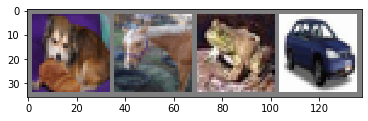

  dog horse  frog automobile


In [10]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 定义网络结构

此处我们使用的是在ImageNet上预训练过的VGG16模型，但是ImageNet是1000分类，而我们的cifar10是10分类，所以需要我们更改下网络的最后一个全连接层

## 直接调用接口加载预训练过的模型

In [11]:
net = torchvision.models.vgg16(pretrained=True)

## 查看网络结构

In [12]:
net.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [13]:
net.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

## 更改网络的最后一个全连接层

In [14]:
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 10)

## 把网络传送到GPU上

In [15]:
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 查看网络处于eval还是training状态

In [16]:
net.training   # 一般来说网络默认是training状态

True

# 定义损失函数和优化器

In [17]:
criterion = nn.CrossEntropyLoss()  # 一般作为分类的损失函数使用
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 通过net.parameters()把所有trainable的参数都传入优化器里

# 开始训练网络，epoch设置为2，并输出损失值

In [18]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # 数据也要传到GPU设备上
        
        optimizer.zero_grad()  # 对梯度进行清零
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # 计算损失值
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        
        running_loss += loss.item() #此处的loss值是单一样本的损失值,而不是mini-batch的，因为criterion计算过程中取了均值
        if i % 2000 == 1999: # 每2000个step输出一次损失值
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.470
[1,  4000] loss: 0.996
[1,  6000] loss: 0.851
[1,  8000] loss: 0.783
[1, 10000] loss: 0.687
[1, 12000] loss: 0.668
[2,  2000] loss: 0.519
[2,  4000] loss: 0.536
[2,  6000] loss: 0.506
[2,  8000] loss: 0.503
[2, 10000] loss: 0.486
[2, 12000] loss: 0.481
Finished Training


# 保存模型权重

这里有个不错的解释: In Pytorch, the learnable parameters(weights and biases) of an torch.nn.Module model are contained in the model's parameters(accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.Note that only layers with learnable parameters(convolutional layers, linear layers) and registered buffers(batchnorm's running_mean) have entries in the model's state_dict. Optimizer objects(torch.optim) also have a state_dict, which contains information about the opimizer's state, as well as the hyperparameters used. Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers

In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)  # 仅仅保存模型参数，torch.save(net, PATH)保存整个模型，包含优化器等
# optimizer.state_dict().keys()可以查看优化器里的参数

# 对测试集进行预测

## 可视化测试集的一个batch图片

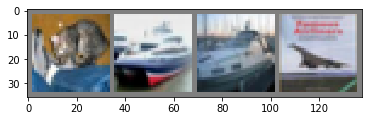

GroundTruth:    cat  ship  ship airplane


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 声明一个类实例，并从.pth加载模型,也就是参数

因为网络里不包含dropout等，所以这里网络的状态直接是training也没事

In [21]:
net = torchvision.models.vgg16(pretrained=True)
# 更改网络的最后一个全连接层
net_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 10)
net.load_state_dict(torch.load(PATH)) # 加载预训练过的模型，也就是参数，一般来说是模型结构+参数，在restore的时候，如果想训练还要优化器
net.to(device)  # 把网络传到GPU设备上

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 对一个batch的测试集图片进行预测

In [22]:
outputs = net(images.to(device))  # 此处要把待预测的图片传到GPU上

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  airplane  ship automobile airplane


## 在10000张测试集上的准确率

计算公式和下面这个理解很类似: Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [24]:
correct = 0
total = 0
with torch.no_grad():  # 推断的时候不需要计算梯度
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) # 把数据传到GPU设备上
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 这个和平常见到的不太一样，可以自己输出一下看看
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


## 在每个类别上的准确率

计算公式和下面这个理解很类似: Recall = TP / (TP + FN)

In [25]:
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
with torch.no_grad():  # 推断的时候不需要计算梯度
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()  # 得到的是一个True和False的列表
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()  # 我测试了，+上一个True等于+1, +上一个False等于+0
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 95 %
Accuracy of automobile : 93 %
Accuracy of  bird : 75 %
Accuracy of   cat : 33 %
Accuracy of  deer : 89 %
Accuracy of   dog : 69 %
Accuracy of  frog : 70 %
Accuracy of horse : 88 %
Accuracy of  ship : 84 %
Accuracy of truck : 88 %
